In [81]:
import sys
sys.path.append('/orange/adamginsburg/ALMA_IMF/reduction/analysis')

In [82]:
import spitzer_plots
from spectralindex import prefixes

In [85]:
prefixes

{'G328': {'finaliter_prefix_b3': 'G328.25/B3/cleanest/G328.25_B3_uid___A001_X1296_X16d_continuum_merged_12M_robust0_selfcal4_finaliter',
  'finaliter_prefix_b6': 'G328.25/B6/cleanest/G328.25_B6_uid___A001_X1296_X163_continuum_merged_12M_robust0_selfcal4_finaliter'},
 'G333': {'finaliter_prefix_b6': 'G333.60/B6/cleanest/G333.60_B6_uid___A001_X1296_X19b_continuum_merged_12M_robust0_selfcal6_finaliter',
  'finaliter_prefix_b3': 'G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal6_finaliter'},
 'G12': {'finaliter_prefix_b3': 'G012.80/B3/cleanest/G012.80_B3_uid___A001_X1296_X1fb_continuum_merged_12M_robust0_selfcal7_finaliter',
  'finaliter_prefix_b6': 'G012.80/B6/cleanest/G012.80_B6_uid___A001_X1296_X1ef_continuum_merged_12M_robust0_selfcal6_finaliter'},
 'W51IRS2': {'finaliter_prefix_b3': 'W51-IRS2/B3/cleanest/W51-IRS2_B3_uid___A001_X1296_X18f_continuum_merged_12M_robust0_selfcal4_finaliter',
  'finaliter_prefix_b6': 'W51-IRS2/B6/cleanest/W51-IRS2_B6

In [86]:
fieldid = 'G008'
pfxs = prefixes[fieldid]

In [95]:
from astropy.visualization import simple_norm

In [111]:
from scipy.ndimage.morphology import binary_dilation, binary_erosion, generate_binary_structure

In [220]:
import reproject

In [221]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector
import astropy.visualization.wcsaxes

/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)
/orange/adamginsburg/repos/spectral-cube/spectral_cube/masks.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return LazyMask(self._function, data=self._data[view],
/orange/adamginsburg/repos/spectral-cube/spectral_cube/masks.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In t

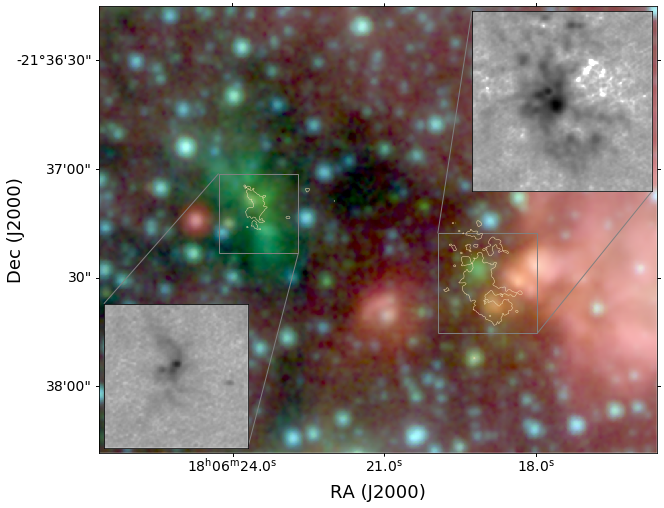

In [222]:
fieldid = 'G008'
pfxs = prefixes[fieldid]

#fig = spitzer_plots.show_fov_on_spitzer(**pfxs, fieldid=fieldid, spitzerpath='spitzer_datapath', contour_level={'B3':[100], 'B6': [100]})
finaliter_prefix_b3 = pfxs['finaliter_prefix_b3']
finaliter_prefix_b6 = pfxs['finaliter_prefix_b6']
image_b3 = SpectralCube.read(f'{finaliter_prefix_b3}.image.tt0.fits', use_dask=False, format='fits')
image_b6 = SpectralCube.read(f'{finaliter_prefix_b6}.image.tt0.fits', use_dask=False, format='fits')

spitzerpath='spitzer_datapath'
spitzfn = f'{spitzerpath}/{fieldid}_spitzer_images.fits'
spitz = fits.open(spitzfn)
spitzheader = spitz[0].header
spitzwcs = wcs.WCS(spitz[0].header)


mask = ((image_b6 > 2.5*image_b6.mad_std()) & (image_b6.mask)).include()
struct1 = generate_binary_structure(2, 1)
mask = binary_erosion(mask[0], structure=struct1, iterations=3)
mask = binary_dilation(mask, iterations=9)

cutimage = image_b6.with_mask(mask[None,:,:]).minimal_subcube()

imdata = cutimage[0].value

spitz_rep = [reproject.reproject_interp((data, spitzwcs.celestial), image_b6[0].header)[0] for data in spitz[0].data]

fig = pl.figure(1, figsize=(10,10))
fig.clf()
ax = fig.add_subplot(projection=image_b6.wcs.celestial)

spitzer_display_args=dict(stretch='log', min_percent=1, max_percent=99.99, clip=True)
spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in spitz_rep])
ax.imshow(spitz_data.T.swapaxes(0,1))
lims = ax.axis()
#ax.imshow(imdata, transform=ax.get_transform(cutimage.wcs.celestial), cmap='Blues_r', norm=simple_norm(imdata, max_percent=99.95, stretch='log'))
norm = simple_norm(imdata, max_percent=99.95, stretch='log')
almadata = np.array([norm(imdata)*210/256., 
                     norm(imdata)*155/256., 
                     norm(imdata)*50/256.,
                     simple_norm(imdata, stretch='log')(imdata)])
#ax.imshow(almadata.T.swapaxes(0,1), transform=ax.get_transform(cutimage.wcs.celestial),)
ax.contour(image_b6[0].value,  transform=ax.get_transform(image_b6.wcs.celestial), levels=image_b6.mad_std()*[5], colors=['wheat'], linewidths=[0.5])
#ax.axis(lims)

tick_fontsize=14
ra = ax.coords['ra']
ra.set_major_formatter('hh:mm:ss.s')
dec = ax.coords['dec']
ra.set_axislabel("RA (J2000)", fontsize=18)
dec.set_axislabel("Dec (J2000)", fontsize=18, minpad=0.0)
ra.ticklabels.set_fontsize(tick_fontsize)
ra.set_ticks(exclude_overlapping=True)
dec.ticklabels.set_fontsize(tick_fontsize)
dec.set_ticks(exclude_overlapping=True)



slc = [slice(300,550), slice(850,1100)]
axins = inset_axes(ax, loc=1, width=2.5, height=2.5,
                   axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=image_b6[0][slc].wcs.celestial))
axins.imshow(image_b6[0].value[slc], extent=[850,1100,300,550], cmap='gray_r', norm=norm)
mark_inset(parent_axes=ax, inset_axes=axins,
           loc1=2, loc2=4, fc="none", ec="0.5")
ra = axins.coords['ra']
dec = axins.coords['dec']
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ra.set_ticks_visible(False)
dec.set_ticks_visible(False)
ra.set_axislabel('')
dec.set_axislabel('')
ra.ticklabels.set_visible(False)
dec.ticklabels.set_visible(False)


bx,tx = (300,500)
by,ty = (500,700)
slc = [slice(by,ty), slice(bx,tx)]
axins = inset_axes(ax, loc=3, width=2, height=2,
                   axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=image_b6[0][slc].wcs.celestial))
axins.imshow(image_b6[0].value[slc], extent=[bx,tx,by,ty], cmap='gray_r', norm=norm)
mark_inset(parent_axes=ax, inset_axes=axins,
           loc1=2, loc2=4, fc="none", ec="0.5")
ra = axins.coords['ra']
dec = axins.coords['dec']
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ra.set_ticks_visible(False)
dec.set_ticks_visible(False)
ra.set_axislabel('')
dec.set_axislabel('')
ra.ticklabels.set_visible(False)
dec.ticklabels.set_visible(False)


ax.axis(lims)

pl.savefig('/orange/adamginsburg/ALMA_IMF/datapaper/figures/G008_Spitzer_zooms.png', bbox_inches='tight')
pl.savefig('/orange/adamginsburg/ALMA_IMF/datapaper/figures/G008_Spitzer_zooms.pdf', bbox_inches='tight')

In [223]:
prefixes.keys()

dict_keys(['G328', 'G333', 'G12', 'W51IRS2', 'G008', 'G327', 'G10', 'G337', 'G338', 'G351', 'G353', 'W43MM3', 'W43MM2', 'W51-E', 'W43MM1'])

/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)
/orange/adamginsburg/repos/spectral-cube/spectral_cube/masks.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return LazyMask(self._function, data=self._data[view],
/orange/adamginsburg/repos/spectral-cube/spectral_cube/masks.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In t

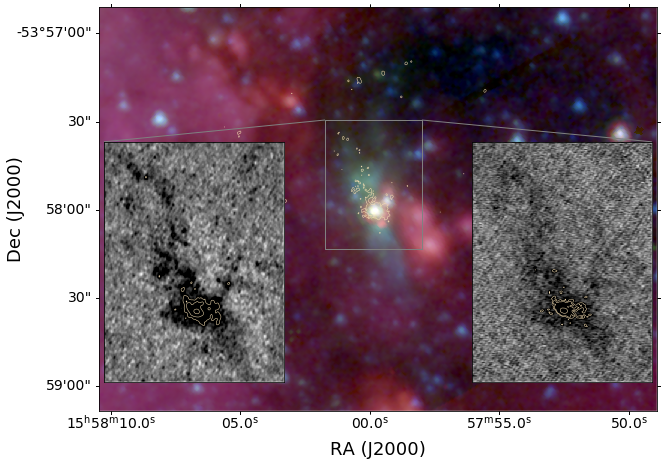

In [240]:
fieldid = 'G328'
pfxs = prefixes[fieldid]

finaliter_prefix_b3 = pfxs['finaliter_prefix_b3']
finaliter_prefix_b6 = pfxs['finaliter_prefix_b6']
image_b3 = SpectralCube.read(f'{finaliter_prefix_b3}.image.tt0.fits', use_dask=False, format='fits')
image_b6 = SpectralCube.read(f'{finaliter_prefix_b6}.image.tt0.fits', use_dask=False, format='fits')

spitzerpath='spitzer_datapath'
spitzfn = f'{spitzerpath}/{fieldid}_spitzer_images.fits'
spitz = fits.open(spitzfn)
spitzheader = spitz[0].header
spitzwcs = wcs.WCS(spitz[0].header)


mask = ((image_b6 > 2.5*image_b6.mad_std()) & (image_b6.mask)).include()
struct1 = generate_binary_structure(2, 1)
mask = binary_erosion(mask[0], structure=struct1, iterations=3)
mask = binary_dilation(mask, iterations=9)

cutimage = image_b6.with_mask(mask[None,:,:]).minimal_subcube()

imdata = cutimage[0].value

spitz_rep = [reproject.reproject_interp((data, spitzwcs.celestial), image_b6[0].header)[0] for data in spitz[0].data]

fig = pl.figure(1, figsize=(10,10))
fig.clf()
ax = fig.add_subplot(projection=image_b6.wcs.celestial)

spitzer_display_args=dict(stretch='log', min_percent=1, max_percent=99.99, clip=True)
spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in spitz_rep])
ax.imshow(spitz_data.T.swapaxes(0,1))
lims = ax.axis()
#ax.imshow(imdata, transform=ax.get_transform(cutimage.wcs.celestial), cmap='Blues_r', norm=simple_norm(imdata, max_percent=99.95, stretch='log'))
norm = simple_norm(imdata, max_percent=99.995, stretch='asinh')
almadata = np.array([norm(imdata)*210/256., 
                     norm(imdata)*155/256., 
                     norm(imdata)*50/256.,
                     simple_norm(imdata, stretch='log')(imdata)])
#ax.imshow(almadata.T.swapaxes(0,1), transform=ax.get_transform(cutimage.wcs.celestial),)
ax.contour(image_b6[0].value,  transform=ax.get_transform(image_b6.wcs.celestial), levels=image_b6.mad_std()*[5], colors=['wheat'], linewidths=[0.5])
#ax.axis(lims)

tick_fontsize=14
ra = ax.coords['ra']
ra.set_major_formatter('hh:mm:ss.s')
dec = ax.coords['dec']
ra.set_axislabel("RA (J2000)", fontsize=18)
dec.set_axislabel("Dec (J2000)", fontsize=18, minpad=0.0)
ra.ticklabels.set_fontsize(tick_fontsize)
ra.set_ticks(exclude_overlapping=True)
dec.ticklabels.set_fontsize(tick_fontsize)
dec.set_ticks(exclude_overlapping=True)



norm = simple_norm(image_b6[0].value, max_percent=99.5, min_percent=0, stretch='linear')

bx,tx = (700,1000)
by,ty = (500,900)
slc = [slice(by,ty), slice(bx,tx)]
axins = inset_axes(ax, loc=3, width=2.5, height=4,
                   axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=image_b6[0][slc].wcs.celestial))
axins.imshow(image_b6[0].value[slc], extent=[bx,tx,by,ty], cmap='gray_r', norm=norm)
axins.contour(image_b6[0].value[slc], extent=[bx,tx,by,ty], levels=np.nanpercentile(image_b6[0].data, [99.8, 99.95, 99.995]), colors=['wheat']*4, linewidths=[0.5]*4)
pp,p1,p2 = mark_inset(parent_axes=ax, inset_axes=axins,
           loc1=2, loc2=2, fc="none", ec="0.5")
p2.set_visible(False)
ra = axins.coords['ra']
dec = axins.coords['dec']
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ra.set_ticks_visible(False)
dec.set_ticks_visible(False)
ra.set_axislabel('')
dec.set_axislabel('')
ra.ticklabels.set_visible(False)
dec.ticklabels.set_visible(False)



image_b3_rep,_ = reproject.reproject_exact((image_b3[0].value, image_b3[0].wcs), image_b6[0].header)
norm = simple_norm(image_b3_rep, max_percent=99.8, min_percent=0, stretch='linear')

axins = inset_axes(ax, loc=4, width=2.5, height=4,
                   axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=image_b6[0][slc].wcs.celestial))
axins.imshow(image_b3_rep[slc], extent=[bx,tx,by,ty], cmap='gray_r', norm=norm)
axins.contour(image_b3_rep[slc], extent=[bx,tx,by,ty], levels=np.nanpercentile(image_b3_rep, [99.9, 99.95, 99.995]), colors=['wheat']*4, linewidths=[0.5]*4)
pp,p1,p2 = mark_inset(parent_axes=ax, inset_axes=axins,
                      loc1=1, loc2=1, fc="none", ec="0.5")
p2.set_visible(False)
ra = axins.coords['ra']
dec = axins.coords['dec']
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ra.set_ticks_visible(False)
dec.set_ticks_visible(False)
ra.set_axislabel('')
dec.set_axislabel('')
ra.ticklabels.set_visible(False)
dec.ticklabels.set_visible(False)




ax.axis(lims)

pl.savefig(f'/orange/adamginsburg/ALMA_IMF/datapaper/figures/{fieldid}_Spitzer_zooms.png', bbox_inches='tight')
pl.savefig(f'/orange/adamginsburg/ALMA_IMF/datapaper/figures/{fieldid}_Spitzer_zooms.pdf', bbox_inches='tight')

/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)
/orange/adamginsburg/repos/spectral-cube/spectral_cube/masks.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return LazyMask(self._function, data=self._data[view],
/orange/adamginsburg/repos/spectral-cube/spectral_cube/masks.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In t

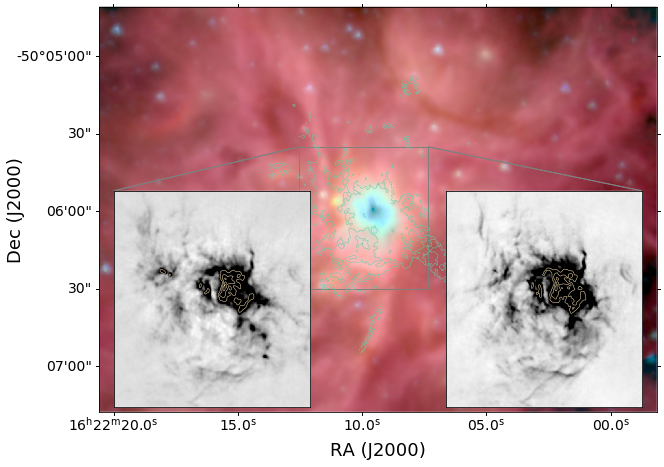

In [255]:
fieldid = 'G333'
pfxs = prefixes[fieldid]

finaliter_prefix_b3 = pfxs['finaliter_prefix_b3']
finaliter_prefix_b6 = pfxs['finaliter_prefix_b6']
image_b3 = SpectralCube.read(f'{finaliter_prefix_b3}.image.tt0.fits', use_dask=False, format='fits')
image_b6 = SpectralCube.read(f'{finaliter_prefix_b6}.image.tt0.fits', use_dask=False, format='fits')

spitzerpath='spitzer_datapath'
spitzfn = f'{spitzerpath}/{fieldid}_spitzer_images.fits'
spitz = fits.open(spitzfn)
spitzheader = spitz[0].header
spitzwcs = wcs.WCS(spitz[0].header)


mask = ((image_b6 > 2.5*image_b6.mad_std()) & (image_b6.mask)).include()
struct1 = generate_binary_structure(2, 1)
mask = binary_erosion(mask[0], structure=struct1, iterations=3)
mask = binary_dilation(mask, iterations=9)

cutimage = image_b6.with_mask(mask[None,:,:]).minimal_subcube()

imdata = cutimage[0].value

spitz_rep = [reproject.reproject_interp((data, spitzwcs.celestial), image_b6[0].header)[0] for data in spitz[0].data]

fig = pl.figure(1, figsize=(10,10))
fig.clf()
ax = fig.add_subplot(projection=image_b6.wcs.celestial)

spitzer_display_args=dict(stretch='log', min_percent=1, max_percent=99.99, clip=True)
spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in spitz_rep])
ax.imshow(spitz_data.T.swapaxes(0,1))
lims = ax.axis()
#ax.imshow(imdata, transform=ax.get_transform(cutimage.wcs.celestial), cmap='Blues_r', norm=simple_norm(imdata, max_percent=99.95, stretch='log'))
norm = simple_norm(imdata, max_percent=99.995, stretch='asinh')
almadata = np.array([norm(imdata)*210/256., 
                     norm(imdata)*155/256., 
                     norm(imdata)*50/256.,
                     simple_norm(imdata, stretch='log')(imdata)])
#ax.imshow(almadata.T.swapaxes(0,1), transform=ax.get_transform(cutimage.wcs.celestial),)
ax.contour(image_b6[0].value,  transform=ax.get_transform(image_b6.wcs.celestial), levels=image_b6.mad_std()*[5], colors=['mediumaquamarine'], linewidths=[0.5])
#ax.axis(lims)

tick_fontsize=14
ra = ax.coords['ra']
ra.set_major_formatter('hh:mm:ss.s')
dec = ax.coords['dec']
ra.set_axislabel("RA (J2000)", fontsize=18)
dec.set_axislabel("Dec (J2000)", fontsize=18, minpad=0.0)
ra.ticklabels.set_fontsize(tick_fontsize)
ra.set_ticks(exclude_overlapping=True)
dec.ticklabels.set_fontsize(tick_fontsize)
dec.set_ticks(exclude_overlapping=True)



norm = simple_norm(image_b6[0].value, max_percent=99.5, min_percent=0, stretch='linear')

bx,tx = (775,1275)
by,ty = (475,1025)
slc = [slice(by,ty), slice(bx,tx)]
axins = inset_axes(ax, loc=3, width=3, height=3,
                   axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=image_b6[0][slc].wcs.celestial))
axins.imshow(image_b6[0].value[slc], extent=[bx,tx,by,ty], cmap='gray_r', norm=norm)
axins.contour(image_b6[0].value[slc], extent=[bx,tx,by,ty], levels=np.nanpercentile(image_b6[0].data, [99.8, 99.95, 99.995]), colors=['wheat']*4, linewidths=[0.5]*4)
mark_inset(parent_axes=ax, inset_axes=axins,
           loc1=2, loc2=2, fc="none", ec="0.5")
ra = axins.coords['ra']
dec = axins.coords['dec']
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ra.set_ticks_visible(False)
dec.set_ticks_visible(False)
ra.set_axislabel('')
dec.set_axislabel('')
ra.ticklabels.set_visible(False)
dec.ticklabels.set_visible(False)



image_b3_rep,_ = reproject.reproject_exact((image_b3[0].value, image_b3[0].wcs), image_b6[0].header)
norm = simple_norm(image_b3_rep, max_percent=99.5, min_percent=0, stretch='linear')

axins = inset_axes(ax, loc=4, width=3, height=3,
                   axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=image_b6[0][slc].wcs.celestial))
axins.imshow(image_b3_rep[slc], extent=[bx,tx,by,ty], cmap='gray_r', norm=norm)
axins.contour(image_b3_rep[slc], extent=[bx,tx,by,ty], levels=np.nanpercentile(image_b3_rep, [99.8, 99.95, 99.995]), colors=['wheat']*4, linewidths=[0.5]*4)
mark_inset(parent_axes=ax, inset_axes=axins,
           loc1=1, loc2=1, fc="none", ec="0.5")
ra = axins.coords['ra']
dec = axins.coords['dec']
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ra.set_ticks_visible(False)
dec.set_ticks_visible(False)
ra.set_axislabel('')
dec.set_axislabel('')
ra.ticklabels.set_visible(False)
dec.ticklabels.set_visible(False)




ax.axis(lims)

pl.savefig(f'/orange/adamginsburg/ALMA_IMF/datapaper/figures/{fieldid}_Spitzer_zooms.png', bbox_inches='tight')
pl.savefig(f'/orange/adamginsburg/ALMA_IMF/datapaper/figures/{fieldid}_Spitzer_zooms.pdf', bbox_inches='tight')

/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)
/orange/adamginsburg/repos/spectral-cube/spectral_cube/masks.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return LazyMask(self._function, data=self._data[view],
/orange/adamginsburg/repos/spectral-cube/spectral_cube/masks.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In t

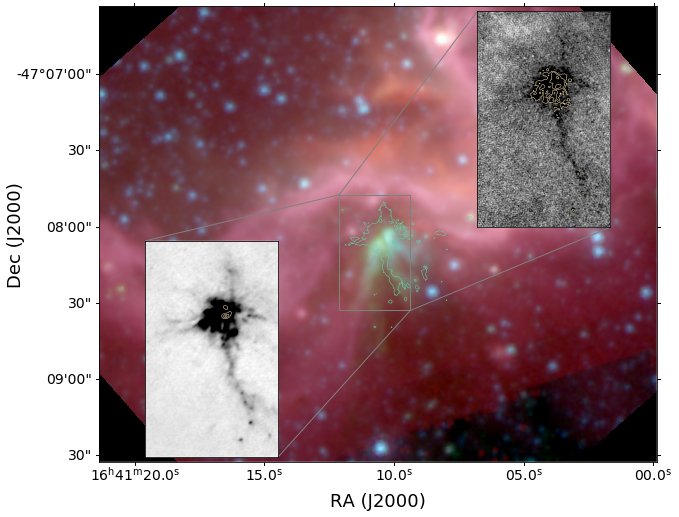

In [267]:
fieldid = 'G337'
pfxs = prefixes[fieldid]

finaliter_prefix_b3 = pfxs['finaliter_prefix_b3']
finaliter_prefix_b6 = pfxs['finaliter_prefix_b6']
image_b3 = SpectralCube.read(f'{finaliter_prefix_b3}.image.tt0.fits', use_dask=False, format='fits')
image_b6 = SpectralCube.read(f'{finaliter_prefix_b6}.image.tt0.fits', use_dask=False, format='fits')

spitzerpath='spitzer_datapath'
spitzfn = f'{spitzerpath}/{fieldid}_spitzer_images.fits'
spitz = fits.open(spitzfn)
spitzheader = spitz[0].header
spitzwcs = wcs.WCS(spitz[0].header)


mask = ((image_b6 > 2.5*image_b6.mad_std()) & (image_b6.mask)).include()
struct1 = generate_binary_structure(2, 1)
mask = binary_erosion(mask[0], structure=struct1, iterations=3)
mask = binary_dilation(mask, iterations=9)

cutimage = image_b6.with_mask(mask[None,:,:]).minimal_subcube()

imdata = cutimage[0].value

spitz_rep = [reproject.reproject_interp((data, spitzwcs.celestial), image_b3[0].header)[0] for data in spitz[0].data]

fig = pl.figure(1, figsize=(10,10))
fig.clf()
ax = fig.add_subplot(projection=image_b3.wcs.celestial)

spitzer_display_args=dict(stretch='log', min_percent=1, max_percent=99.99, clip=True)
spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in spitz_rep])
ax.imshow(spitz_data.T.swapaxes(0,1))
lims = ax.axis()
#ax.imshow(imdata, transform=ax.get_transform(cutimage.wcs.celestial), cmap='Blues_r', norm=simple_norm(imdata, max_percent=99.95, stretch='log'))
norm = simple_norm(imdata, max_percent=99.995, stretch='asinh')
almadata = np.array([norm(imdata)*210/256., 
                     norm(imdata)*155/256., 
                     norm(imdata)*50/256.,
                     simple_norm(imdata, stretch='log')(imdata)])
#ax.imshow(almadata.T.swapaxes(0,1), transform=ax.get_transform(cutimage.wcs.celestial),)
ax.contour(image_b6[0].value,  transform=ax.get_transform(image_b6.wcs.celestial), levels=image_b6.mad_std()*[5], colors=['mediumaquamarine'], linewidths=[0.5])
#ax.axis(lims)

tick_fontsize=14
ra = ax.coords['ra']
ra.set_major_formatter('hh:mm:ss.s')
dec = ax.coords['dec']
ra.set_axislabel("RA (J2000)", fontsize=18)
dec.set_axislabel("Dec (J2000)", fontsize=18, minpad=0.0)
ra.ticklabels.set_fontsize(tick_fontsize)
ra.set_ticks(exclude_overlapping=True)
dec.ticklabels.set_fontsize(tick_fontsize)
dec.set_ticks(exclude_overlapping=True)


image_b6_rep,_ = reproject.reproject_exact((image_b6[0].value, image_b6[0].wcs), image_b3[0].header)


norm = simple_norm(image_b6[0].value, max_percent=99.5, min_percent=0, stretch='linear')

bx,tx = (1350,1750)
by,ty = (850,1500)
slc = [slice(by,ty), slice(bx,tx)]
axins = inset_axes(ax, loc=3, width=3, height=3,
                   axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=image_b6[0][slc].wcs.celestial))
axins.imshow(image_b6_rep[slc], extent=[bx,tx,by,ty], cmap='gray_r', norm=norm)
axins.contour(image_b6_rep[slc], extent=[bx,tx,by,ty], levels=np.nanpercentile(image_b6_rep[slc], [99.8, 99.95, 99.995]), colors=['wheat']*4, linewidths=[0.5]*4)
mark_inset(parent_axes=ax, inset_axes=axins,
           loc1=2, loc2=4, fc="none", ec="0.5")
ra = axins.coords['ra']
dec = axins.coords['dec']
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ra.set_ticks_visible(False)
dec.set_ticks_visible(False)
ra.set_axislabel('')
dec.set_axislabel('')
ra.ticklabels.set_visible(False)
dec.ticklabels.set_visible(False)



#image_b3_rep,_ = reproject.reproject_exact((image_b3[0].value, image_b3[0].wcs), image_b6[0].header)
image_b3_rep = image_b3[0].value
norm = simple_norm(image_b3_rep, max_percent=99.5, min_percent=0, stretch='linear')

axins = inset_axes(ax, loc=1, width=3, height=3,
                   axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=image_b6[0][slc].wcs.celestial))
axins.imshow(image_b3_rep[slc], extent=[bx,tx,by,ty], cmap='gray_r', norm=norm)
axins.contour(image_b3_rep[slc], extent=[bx,tx,by,ty], levels=np.nanpercentile(image_b3_rep, [99.8, 99.95, 99.995]), colors=['wheat']*4, linewidths=[0.5]*4)
mark_inset(parent_axes=ax, inset_axes=axins,
           loc1=2, loc2=4, fc="none", ec="0.5")
ra = axins.coords['ra']
dec = axins.coords['dec']
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ra.set_ticks_visible(False)
dec.set_ticks_visible(False)
ra.set_axislabel('')
dec.set_axislabel('')
ra.ticklabels.set_visible(False)
dec.ticklabels.set_visible(False)




ax.axis(lims)

pl.savefig(f'/orange/adamginsburg/ALMA_IMF/datapaper/figures/{fieldid}_Spitzer_zooms.png', bbox_inches='tight')
pl.savefig(f'/orange/adamginsburg/ALMA_IMF/datapaper/figures/{fieldid}_Spitzer_zooms.pdf', bbox_inches='tight')

/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)
/orange/adamginsburg/repos/spectral-cube/spectral_cube/masks.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return LazyMask(self._function, data=self._data[view],
/orange/adamginsburg/repos/spectral-cube/spectral_cube/masks.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In t

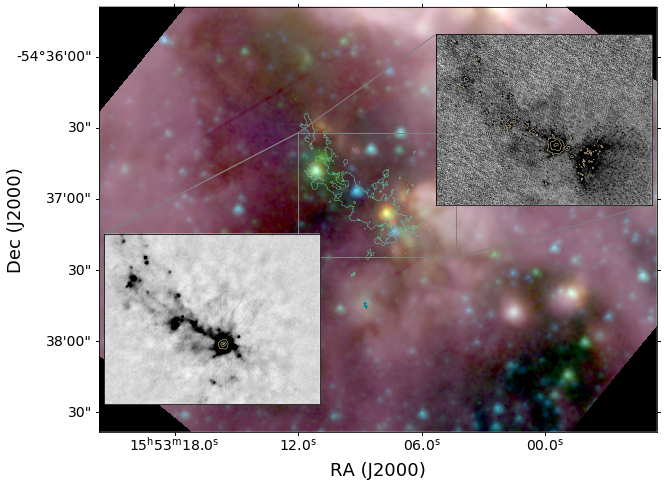

In [266]:
fieldid = 'G327'
pfxs = prefixes[fieldid]

finaliter_prefix_b3 = pfxs['finaliter_prefix_b3']
finaliter_prefix_b6 = pfxs['finaliter_prefix_b6']
image_b3 = SpectralCube.read(f'{finaliter_prefix_b3}.image.tt0.fits', use_dask=False, format='fits')
image_b6 = SpectralCube.read(f'{finaliter_prefix_b6}.image.tt0.fits', use_dask=False, format='fits')

spitzerpath='spitzer_datapath'
spitzfn = f'{spitzerpath}/{fieldid}_spitzer_images.fits'
spitz = fits.open(spitzfn)
spitzheader = spitz[0].header
spitzwcs = wcs.WCS(spitz[0].header)


mask = ((image_b6 > 2.5*image_b6.mad_std()) & (image_b6.mask)).include()
struct1 = generate_binary_structure(2, 1)
mask = binary_erosion(mask[0], structure=struct1, iterations=3)
mask = binary_dilation(mask, iterations=9)

cutimage = image_b6.with_mask(mask[None,:,:]).minimal_subcube()

imdata = cutimage[0].value

spitz_rep = [reproject.reproject_interp((data, spitzwcs.celestial), image_b3[0].header)[0] for data in spitz[0].data]

fig = pl.figure(1, figsize=(10,10))
fig.clf()
ax = fig.add_subplot(projection=image_b3.wcs.celestial)

spitzer_display_args=dict(stretch='log', min_percent=1, max_percent=99.99, clip=True)
spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in spitz_rep])
ax.imshow(spitz_data.T.swapaxes(0,1))
lims = ax.axis()
#ax.imshow(imdata, transform=ax.get_transform(cutimage.wcs.celestial), cmap='Blues_r', norm=simple_norm(imdata, max_percent=99.95, stretch='log'))
norm = simple_norm(imdata, max_percent=99.995, stretch='asinh')
almadata = np.array([norm(imdata)*210/256., 
                     norm(imdata)*155/256., 
                     norm(imdata)*50/256.,
                     simple_norm(imdata, stretch='log')(imdata)])
#ax.imshow(almadata.T.swapaxes(0,1), transform=ax.get_transform(cutimage.wcs.celestial),)
ax.contour(image_b6[0].value,  transform=ax.get_transform(image_b6.wcs.celestial), levels=image_b6.mad_std()*[5], colors=['mediumaquamarine'], linewidths=[0.5])
#ax.axis(lims)

tick_fontsize=14
ra = ax.coords['ra']
ra.set_major_formatter('hh:mm:ss.s')
dec = ax.coords['dec']
ra.set_axislabel("RA (J2000)", fontsize=18)
dec.set_axislabel("Dec (J2000)", fontsize=18, minpad=0.0)
ra.ticklabels.set_fontsize(tick_fontsize)
ra.set_ticks(exclude_overlapping=True)
dec.ticklabels.set_fontsize(tick_fontsize)
dec.set_ticks(exclude_overlapping=True)


image_b6_rep,_ = reproject.reproject_exact((image_b6[0].value, image_b6[0].wcs), image_b3[0].header)


norm = simple_norm(image_b6[0].value, max_percent=99.5, min_percent=0, stretch='linear')

bx,tx = (1200,2150)
by,ty = (1050,1800)
slc = [slice(by,ty), slice(bx,tx)]
axins = inset_axes(ax, loc=3, width=3, height=3,
                   axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=image_b6[0][slc].wcs.celestial))
axins.imshow(image_b6_rep[slc], extent=[bx,tx,by,ty], cmap='gray_r', norm=norm)
axins.contour(image_b6_rep[slc], extent=[bx,tx,by,ty], levels=np.nanpercentile(image_b6_rep[slc], [99.8, 99.95, 99.995]), colors=['wheat']*4, linewidths=[0.5]*4)
mark_inset(parent_axes=ax, inset_axes=axins,
           loc1=2, loc2=2, fc="none", ec="0.5")
ra = axins.coords['ra']
dec = axins.coords['dec']
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ra.set_ticks_visible(False)
dec.set_ticks_visible(False)
ra.set_axislabel('')
dec.set_axislabel('')
ra.ticklabels.set_visible(False)
dec.ticklabels.set_visible(False)



#image_b3_rep,_ = reproject.reproject_exact((image_b3[0].value, image_b3[0].wcs), image_b6[0].header)
image_b3_rep = image_b3[0].value
norm = simple_norm(image_b3_rep, max_percent=99.5, min_percent=0, stretch='linear')

axins = inset_axes(ax, loc=1, width=3, height=3,
                   axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=image_b6[0][slc].wcs.celestial))
axins.imshow(image_b3_rep[slc], extent=[bx,tx,by,ty], cmap='gray_r', norm=norm)
axins.contour(image_b3_rep[slc], extent=[bx,tx,by,ty], levels=np.nanpercentile(image_b3_rep, [99.8, 99.95, 99.995]), colors=['wheat']*4, linewidths=[0.5]*4)
mark_inset(parent_axes=ax, inset_axes=axins,
           loc1=2, loc2=4, fc="none", ec="0.5")
ra = axins.coords['ra']
dec = axins.coords['dec']
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ra.set_ticks_visible(False)
dec.set_ticks_visible(False)
ra.set_axislabel('')
dec.set_axislabel('')
ra.ticklabels.set_visible(False)
dec.ticklabels.set_visible(False)




ax.axis(lims)

pl.savefig(f'/orange/adamginsburg/ALMA_IMF/datapaper/figures/{fieldid}_Spitzer_zooms.png', bbox_inches='tight')
pl.savefig(f'/orange/adamginsburg/ALMA_IMF/datapaper/figures/{fieldid}_Spitzer_zooms.pdf', bbox_inches='tight')